# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head(30)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story
6,Michael Booth,fresh,114709,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559,Toy story
7,Geoff Andrew,fresh,114709,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559,Toy story
8,Janet Maslin,fresh,114709,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559,Toy story
9,Kenneth Turan,fresh,114709,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559,Toy story
10,Susan Wloszczyna,fresh,114709,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,True,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,True,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,True,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,True,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,True,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


,count,unique,top,freq
critic,,,,
Bosley Crowther,141,2,True,98
Dave Kehr,338,2,True,200
Derek Adams,151,2,True,93


,count,mean,std,min,25%,50%,75%,max
critic,,,,,,,,
Bosley Crowther,141.0,48033.950355,8988.954189,32455.0,40366.0,48750.0,56218.00,66892.0
Dave Kehr,338.0,67932.434911,23476.167947,13442.0,48653.0,73584.5,87106.25,120815.0
Derek Adams,151.0,103973.066225,74123.667625,17136.0,79742.0,105435.0,118930.50,838232.0


,count,unique,top,freq
critic,,,,
Bosley Crowther,141,1,New York Times,141
Dave Kehr,338,3,Chicago Reader,301
Derek Adams,151,1,Time Out,151


critic
Bosley Crowther       0.695035
Dave Kehr             0.591716
Derek Adams           0.615894
Desson Thomson        0.588235
Edward Guthmann       0.638655
Emanuel Levy          0.629630
Geoff Andrew          0.707736
Hal Hinson            0.530055
James Berardinelli    0.603234
Janet Maslin          0.708738
Name: fresh, dtype: float64

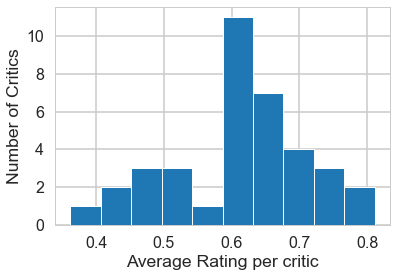

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'

# fresh is a possitive review, rotten is a negative review, converted to true and false
display(df.head())

grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

#print(grp.groups['A.D. Murphy'])
#print(grp.groups['Bosley Crowther'])
#print(grp.fresh.describe()[:10])
#print(grp.imdb.describe()[:10])
#print(grp.publication.describe()[:10])
hvolc = ['Bosley Crowther','Dave Kehr','Derek Adams']
display(grp.fresh.describe().loc[hvolc])
display(grp.imdb.describe().loc[hvolc])
display(grp.publication.describe().loc[hvolc])
display(means[counts > 100][:10])

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

#### Answer:
The Histogram shows an bias in the rating selections of the critics, the distribution shows two peaks in other words it is bi-modal. Frequent Critics are more likely to be either a negative reviewer or a positive reviewer - with many more positive reviewers than negative ones. The most frequent review behavior seen is to give positive reviews 50-60% of the time, a positive reviewer. This could be because people want to watch movies they like and don't want to admit they have wasted their time by watching a movie they didn't enjoy.

Negative reviewers are will give positive reviews between 40-55% of the time - so still tend to watch movies they like half of the time.

-----

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [7]:
#your turn
import sklearn.cross_validation
import sklearn.naive_bayes

xtrain, xtest, ytrain, ytest = sklearn.cross_validation.train_test_split(X, y)
classifier = sklearn.naive_bayes.MultinomialNB()
classifier.fit(xtrain, ytrain)

print("Multinomial model Accuracy (training data): {:0.2f}".format(100 * classifier.score(xtrain, ytrain)))
print("Multinomial model Accuracy (test data): {:0.2f}".format(100 * classifier.score(xtest, ytest)))

Multinomial model Accuracy (training data): 91.71
Multinomial model Accuracy (test data): 78.05


/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Answer:
The multi-nomial model Accuracy for the training set is much higher than the Accuracy for the test set. This is often a sign that the model is overfitting.
This classifier is not particularly good, it isn't generalizing well enough to fit new data.
Regularization may make the model more robust to generalizing to data it hasn't seen before.

-----

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [8]:
# Your turn.
vectorizer = CountVectorizer(min_df=0)
X = vectorizer.fit_transform(critics.quote)
x = X.toarray()

word_df = pd.DataFrame(x, columns=vectorizer.get_feature_names())
word_counts = word_df[word_df > 0.0].count(axis=0)

In [9]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [10]:
word_counts.sort_values(ascending=False)[:20]

the      9502
and      7552
of       7133
is       5120
to       4957
it       4312
in       3672
that     3290
but      2360
with     2359
this     2260
film     2205
movie    2128
as       1987
for      1966
an       1739
its      1661
be       1319
on       1307
has      1254
dtype: int64

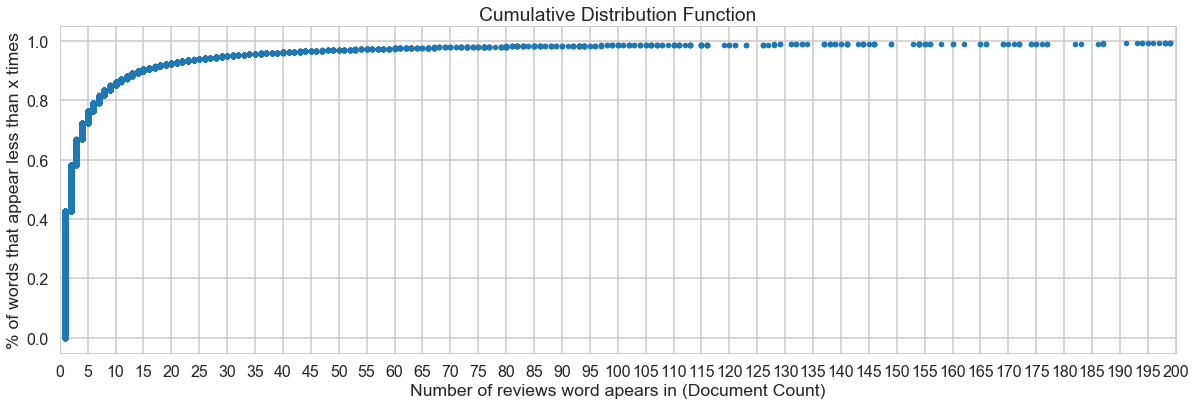

In [11]:
plt.rcParams["figure.figsize"] = (20,6)
x, y = ecdf(word_counts.values)
# Plot the ECDF
_ = plt.plot(x, y, '.')
_ = plt.xlim(0,200)
_ = plt.xticks(np.arange(0, 200+1, 5.0))
_ = plt.xlabel("Number of reviews word apears in (Document Count)")
_ = plt.ylabel("% of words that appear less than x times")
_ = plt.title("Cumulative Distribution Function")
plt.show()

#### Answer:
Looking at the cumulative distribution function you can see that a lot of words appear less then 5 times, almost 75% of words in fact. By selecting a df_min = 2 you would cut out over 50% of words that aren't frequently used and therefore only lend noise to the model.

max_df should be selected to be where the curve starts to plateau and is a sign that the word is so common it is unlikely to carry much value. df_max = 55 would be a good value.

-----

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [12]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [13]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [14]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

#### Answer:
Using the Log_likelihood as the measure of score means that we are summing the log probability of a particular review being a rotten one and the probability of a particular review being a good (aka fresh) one. 
The higher the log likelihood the better the model.

If Alpha is too high it will cause prevent the algorithm learning well from the data we have - more data will be needed to over come the extra counts that alpha will give features that would otherwise be zero.

-----

In [15]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 0.5, 1, 2, 5, 10, 50]
best_min_df = 2 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    print(alpha, score)
    if score > maxscore:
        best_alpha, maxscore = alpha, score
        
print ("The best Alpha is {} giving a highest score of {:0.2f}".format(best_alpha, maxscore))

0.1 -981.8816990675753
0.5 -688.8069237365173
1 -638.1302538406222
2 -709.0983115068799
5 -1001.6608933665133
10 -1216.1028275191175
50 -1302.6885592700876
The best Alpha is 1 giving a highest score of -638.13


In [16]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [17]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.937460
Accuracy on test data:     0.746328


In [18]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2469 1799]
 [ 964 5660]]


#### Answer:
Initial model:
Multinomial model Accuracy (training data): 91.99
Multinomial model Accuracy (test data): 77.05

Tuning the hyper-parameter alpha has improved our naive bayes model taking the training accuracy from 91.99% to 93.21% however the performance on the test data actually dropped, going from 77% accuracy to 74% accuracy - if anything this model suffers from even more over fitting than the original un-tuned model.

-----

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [19]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)      # Returns the indices that would sort an array.

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
                rare 0.96
             delight 0.95
           excellent 0.95
          delightful 0.95
            touching 0.95
               solid 0.94
            portrait 0.94
         beautifully 0.94
              decade 0.94
             kubrick 0.94
Bad words	     P(fresh | word)
               banal 0.12
          uninspired 0.12
               tepid 0.12
             muddled 0.12
             numbing 0.11
        unsatisfying 0.11
           pointless 0.10
             tedious 0.09
               bland 0.07
                lame 0.07


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the indentity matrix represent?</p>

</div>

#### Answer:
creating an identity matrix the size of dictionary of words allows you to 'test' each word independently creating a prediction for each word on its own. ie what is the probability that a review containing just that one word would be a positive or negative review.

The top and bottom 10 probabilities returned for the positive cases then indicate which words most strongly indicate a positive review or conversely least strongly indicate a positive review.

-----

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [20]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
The spirited cast of Jamie Lee Curtis, Kevin Kline and Monty Pythonites John Cleese and Michael Palin is willing. But this tossed-together trifle about an unassuming British zoo taken over by a money-mad Murdochian media mogul is weak.

Herzog offers some evidence of Kinski's great human warmth, somewhat more of his rage of unimaginable proportions, and a good demonstration of Kinski's uncanny capacity to corkscrew his way into the frame.

While Leone's vision still has a magnificent sweep, the film finally subsides to an emotional core that is sombre, even elegiac, and which centres on a man who is bent and broken by time, and finally left with nothing but an impotent sadness.

While Last Days succeeds as a nature documentary, Van Sant fails to penetrate human nature. The result is a portrait without a face.

At best, it is fun. But "fun" is not an aesthetic experience: fun remains on the surface. I have nothing against the surfa

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [21]:
#your turn

vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
clf = MultinomialNB(alpha = best_alpha).fit(X,y)

new_rev = "This movie is not remarkable, touching, or superb in any way"
print(clf.predict_proba(vectorizer.transform([new_rev]))[:, 1])

[0.99947949]


#### Answer:

Our newly trained classifier is indicating that this new review is very likely to be a good one. This is an error and quite likely to be one, if we look carefully at the words used - the 'not' actually flips the meaning of a number of words that otherwise strongly indicate a good movie - 'remarkable', 'touching', 'superb'. This is one of the main weakness' of models that work with a 'bay of words' they are simple and easy to use, but don't handle changes in meaning when words have a 'not' or other modifier near them.

-----

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [22]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [23]:
# Your turn

#### Answer:
##### Naive Bayes model with N-grams

In [28]:
from sklearn.naive_bayes import MultinomialNB

n_grams = [1,2,3,4,5,6]
alphas = [.1, 1, 5, 10, 50]
best_min_df = 2

best_alpha = None
maxscore = -np.inf
best_ngram = None

for n_gram in n_grams:
    for alpha in alphas: 
        vectorizer = CountVectorizer(min_df = best_min_df, ngram_range = (1,n_gram))
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha = alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        print(n_gram, alpha, score)
        if score > maxscore:
            best_ngram, best_alpha, maxscore = n_gram, alpha, score
            
print ("The best n_gram is {}, The best Alpha is {} giving a highest score of {:0.2f}".format(best_ngram, best_alpha, maxscore))
print()

best_alpha = None
maxscore = -np.inf
best_ngram = None

for n_gram in n_grams:
    for alpha in alphas: 
        # this will only pick out n_gram that are 'n_gram' long
        vectorizer = CountVectorizer(min_df = best_min_df, ngram_range = (n_gram,n_gram))
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha = alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        print(n_gram, alpha, score)
        if score > maxscore:
            best_ngram, best_alpha, maxscore = n_gram, alpha, score
print ("The best n_gram is {}, The best Alpha is {} giving a highest score of {:0.2f}".format(best_ngram, best_alpha, maxscore))


1 0.1 -981.8816990675753
1 1 -638.1302538406222
1 5 -1001.6608933665133
1 10 -1216.1028275191175
1 50 -1302.6885592700876
2 0.1 -1506.851020137609
2 1 -872.0227742140527
2 5 -1399.1513098316268
2 10 -1560.5622215868952
2 50 -1453.6215146830507
3 0.1 -1793.651829420247
3 1 -971.8082955657031
3 5 -1475.5983977404908
3 10 -1613.6011630959285
3 50 -1468.4383441327532
4 0.1 -1887.6735567427295
4 1 -998.5125327613026
4 5 -1490.1766457688132
4 10 -1623.1857495092063
4 50 -1470.8437120714793
5 0.1 -1907.3056193950742
5 1 -1003.0267356300644
5 5 -1492.3730158480155
5 10 -1624.681354901567
5 50 -1471.2277673470844
6 0.1 -1913.4556454717244
6 1 -1004.8392614397278
6 5 -1492.941571637346
6 10 -1625.019349566037
6 50 -1471.3169779017314
The best n_gram is 1, The best Alpha is 1 giving a highest score of -638.13

1 0.1 -981.8816990675753
1 1 -638.1302538406222
1 5 -1001.6608933665133
1 10 -1216.1028275191175
1 50 -1302.6885592700876
2 0.1 -1253.666349022727
2 1 -709.7646208939252
2 5 -652.5724740411

In [32]:
vectorizer = CountVectorizer(min_df=best_min_df, ngram_range = (best_ngram,best_ngram))
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Using n_gram range {}, and Alpha of {}".format(best_ngram, best_alpha))
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Using n_gram range 3, and Alpha of 5
Accuracy on training data: 0.776612
Accuracy on test data:     0.620547


The model seems to be overfitting a little less as the accuracy on the training and test data are closer, however the performance is lower than the initial single word model:
Accuracy on training data: 0.937460
Accuracy on test data:     0.746328

##### Random Forest Classifier and Logistic Regression

In [36]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [10,100,250,500]
best_min_df = 2

best_nest = None
maxscore = -np.inf

for n_est in n_estimators: 
        vectorizer = CountVectorizer(min_df = best_min_df)
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = RandomForestClassifier(n_estimators=n_est).fit(xtrain,ytrain)
        score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        print(n_est, score)
        if score > maxscore:
            best_nest, maxscore = n_est, score
print ("The best n_estimator is {} giving a highest score of {:0.2f}".format(best_nest, maxscore)

/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:620: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:620: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:620: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:620: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:620: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


10 -inf


/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:620: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


100 -552.4262120076671
250 -550.2842076001502
500 -550.3056779805612


In [46]:

vectorizer = CountVectorizer(min_df = best_min_df)
X,y = make_xy(critics, vectorizer)
xtrain = X[mask]
ytrain = y[mask]
xtest = X[~mask]
ytest = y[~mask]

clf = RandomForestClassifier(n_estimators=200).fit(xtrain,ytrain)
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Using n_estimators {}".format(200))
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data: {:2f}".format(test_accuracy))

Using n_estimators range 200
Accuracy on training data: 0.999786
Accuracy on test data: 0.680224


In [44]:
from sklearn.linear_model import LogisticRegression

cs = [1,5,10,50,100]
best_min_df = 2

best_c = None
maxscore = -np.inf

for reg in ['l1','l2']:
    for c in cs: 
            vectorizer = CountVectorizer(min_df = best_min_df)
            Xthis, ythis = make_xy(critics, vectorizer)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            clf = LogisticRegression(penalty=reg, C=c).fit(xtrain,ytrain)
            score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
            print(reg, c, score)
            if score > maxscore:
                b_reg, best_c, maxscore = reg, c, score
print ("The best C is {}, with {} reg giving a highest score of {:0.2f}".format(best_c, b_reg, maxscore))

l1 1 -565.4878431294392
l1 5 -819.2656475175066
l1 10 -995.5986915470978


/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1356: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


l1 50 -1445.174681242639
l1 100 -1644.2649364190772
l2 1 -541.2985566266209
l2 5 -638.8820692950253
l2 10 -709.6038608330456
l2 50 -931.8077557818309
l2 100 -1047.7848246921517
The best C is 1, with l2 reg giving a highest score of -541.30


In [47]:

vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = LogisticRegression(penalty=b_reg, C=best_c).fit(xtrain, ytrain)
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Using Regularization type {} and C (reg strength) of {}".format(b_reg, best_c))
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Using Regularization type l2 and C (reg strength) of 1
Accuracy on training data: 0.979225
Accuracy on test data:     0.728425


The Random Forest classifier seriously over fit (common issue with forests)

LogisticRegression was better but still not quite as good as the Naive Bayes model

##### TD-idf with and without stopwords

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer(min_df = 2, ngram_range = (best_ngram,best_ngram))
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha = best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Using n_gram range {}, and Alpha of {}".format(best_ngram, best_alpha))
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Using n_gram range 3, and Alpha of 5
Accuracy on training data: 0.617263
Accuracy on test data:     0.608520


/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [51]:

tfidfvectorizer = TfidfVectorizer(min_df = 2, stop_words = "english", ngram_range = (best_ngram,best_ngram))
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha = best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Using n_gram range {}, and Alpha of {}".format(best_ngram, best_alpha))
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Using n_gram range 3, and Alpha of 5
Accuracy on training data: 0.612337
Accuracy on test data:     0.608153


/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Removing stop words help a little bit, but both these models also perform worse than the Naive Bayes

In [53]:
tfidfvectorizer = TfidfVectorizer(min_df = 2, stop_words = "english")
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha = 1).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Using n_gram range {}, and Alpha of {}".format('none', 1))
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Using n_gram range none, and Alpha of 1
Accuracy on training data: 0.856072
Accuracy on test data:     0.689956


/Users/alisonkline/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


TfidfVectorizer needs to be optimized for ngrams independently of the Vectorizer.

Used with single words the model over fit badly, removing stop words increased the accuracy a tiny bit. Adding in alpha and ngrams solved the over fitting issue, but lowered the over all accuracy.